## Comparison of ML models for virus miRNAs prediction

This notebook reproduces the numerical comparison of three different machine learning models trained to predict virus miRNAs, as described in:


> L. A. Bugnon, J. Raad, G.A. Merino, C. Yones, F. Ariel, D.H. Milone, Senior Member,  IEEE, G. Stegmayer, "Machine learning for the discovery of new miRNAs: helping the fight against COVID-19 ", (under review).


It can easily run in a stand alone way with [Google Colaboratory](https://colab.research.google.com/), otherwise a python instalation is required. 

All models were trained using the sugested hyperparameter sets from 

>   C. Yones, J. Raad, L. Bugnon, D. H. Milone and G. Stegmayer, High precision in microRNA prediction: a novel genome-wide approach based on convolutional deep residual networks (under review, [DOI](https://doi.org/10.1101/2020.10.23.352179))  

>   L. A. Bugnon, C. Yones, D. H. Milone and G. Stegmayer, Deep neural architectures for highly imbalanced data in bioinformatics,
IEEE Transactions on Neural Networks and Learning Systems, 2019 ([DOI](https://doi.org/10.1109/tnnls.2019.2914471)).


### Install and import packages
Run this cell to download the dataset and install all required libraries. 

In [ ]:
import os

# Download dataset
! wget https://sourceforge.net/projects/sourcesinc/files/aicovid/dataset.tar.gz
! tar -xvf dataset.tar.gz
# Download predefined partitions for reproducibility 
! wget https://sourceforge.net/projects/sourcesinc/files/aicovid/test_partitions.pk

# Install required python packages
! wget https://sourceforge.net/projects/sourcesinc/files/aicovid/requirements.txt
! pip install -r "requirements.txt"

# Install mirDNN framework
! git clone --recurse-submodules https://github.com/cyones/mirDNN.git
! cd mirDNN
! pip install -r requirements.txt
! cd ..

import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from deesom import DeeSOM
import pickle
from scipy.stats import zscore 
from Bio import Seq, SeqIO

### Prepare dataset

mirBase virus miRNAs are used as positive class, along with non-mirna hairpin-like sequences from the human genome. Data is split to perform a 10-fold cross-validation with each method. 

In [ ]:
# all the known virus miRNAs are used as positive examples
features_virus_mirnas = pd.read_csv('dataset/features_virus_miRNAs.csv')

# The negative set is composed of a random set of hsa hairpin-like sequences 
features_unlabeled_hairpins = pd.read_csv('dataset/features_unlabeled_hairpins.csv') # Hairpins from hsa genome

labels = np.concatenate((np.ones(len(features_virus_mirnas)), np.zeros(len(features_unlabeled_hairpins))))
features = np.concatenate((features_virus_mirnas.drop(columns=["sequence_names"]), 
                       features_unlabeled_hairpins.drop(columns=["sequence_names"]))).astype(np.float)
sequence_names = np.concatenate((features_virus_mirnas.sequence_names, features_unlabeled_hairpins.sequence_names))

# Feature normalization
features[np.where(np.isnan(features))] = 0
features = zscore(features, axis=0)
features[np.where(np.isnan(features))] = 0

test_ind = pickle.load(open("test_partitions.pk", "rb"))
nfolds = 10

### Run experiment: train and evaluate each model with 10 repetitions

In [ ]:
scores = {}

#### OC-SVM

In [ ]:
for imb in ["1:50", "1:100", "1:200"]:
    m_name = "OC-SVM " + imb
    scores[m_name] = []
    for fold in range(nfolds):
        print("%s fold %d/%d" % (m_name, fold + 1, nfolds))
        train_ind = np.array(list(set(np.arange(len(labels))) - set(test_ind[imb][fold])))
        
        # Train
        model= OneClassSVM(kernel="linear")
        model.fit(features[train_ind, :][labels[train_ind] == 1, :]) # OC-SVM uses only the positive set to fit

        # Test
        scores[m_name].append(model.decision_function(features[test_ind[imb][fold], :]))
print("Done!")

#### deeSOM

In [ ]:
for imb in ["1:50", "1:100", "1:200"]:
    m_name = "deeSOM_full_train_data" + imb
    scores[m_name] = []
    for fold in range(nfolds):
        print("%s fold %d/%d" % (m_name, fold + 1, nfolds))
        train_ind = np.array(list(set(np.arange(len(labels))) - set(test_ind[imb][fold])))
               
        # Train
        model = DeeSOM(verbosity=True)
        model.fit(features[train_ind, :], labels[train_ind]) 

        # Test
        scores[m_name].append(model.predict_proba(features[test_ind[imb][fold], :]))
        pickle.dump(scores, open("tmp_scores_deesom.pk", "wb"))

print("Done!")

#### mirDNN

In [ ]:
import shutil
npos = int(np.sum(labels))

imb = "1:200" # Change to use "1:50", "1:100" or "1:200" imbalance ratio

def split_fasta(seq_len, ind_a, fname_in, handler_a, handler_b, maxb=None):
    ind = np.zeros(seq_len)
    ind[ind_a] = 1
    na, nb = 0, 0
    for record, a in zip(SeqIO.parse(fname_in, "fasta"), ind):
        if a:
            SeqIO.write(record, handler_a, "fasta")
            na += 1
        else:
            if (maxb is not None) and (nb>maxb):
                continue
            SeqIO.write(record, handler_b, "fasta")
            nb += 1

    return nb, na 


for fold in range(9, nfolds):
    test_neg_ind, test_pos_ind = [], [] 
    if os.path.isdir("tmp/"):
      shutil.rmtree("tmp/")
    os.mkdir("tmp/")
    # split folds
    for t in sorted(test_ind[imb][fold]):
        if t<npos:
            test_pos_ind.append(t)
        else:
            test_neg_ind.append(t - npos)    

    with open("tmp/negative_sequences.fold", "w") as oneg, open("tmp/positive_sequences.fold", "w") as opos, open("tmp/test_sequences.fold", "w") as otest: 
        
        ptrain, ptest = split_fasta(npos, test_pos_ind, "dataset/sequences_virus_miRNAs.fold", 
                    otest, opos)
        # Use only a number of negatives to match imbalance ratio
        ntrain = ptrain * (int(imb.split(":")[1]) - 1)
        ntrain, ntest = split_fasta(len(features_unlabeled_hairpins), test_neg_ind, "dataset/sequences_unlabeled_hairpins.fold", otest, oneg, maxb=ntrain)
        print("train", ptrain, ntrain)    
        print("test", ptest, ntest)    
    # Run train script
    ! python3 mirDNN/mirdnn_fit.py -i tmp/negative_sequences.fold -i tmp/positive_sequences.fold -m tmp/out_model.pmt -l tmp/train_{imb}_{fold}.log -d "cuda" -s 160

    # Run test script
    ! python3 mirDNN/mirdnn_eval.py -i tmp/test_sequences.fold -o res/mirdnn_predictions_{imb}_{fold}.csv -m tmp/out_model.pmt -s 160 -d "cuda"
    

### Analyze results

In [ ]:
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt 
from sklearn.metrics import precision_recall_curve
from scipy.interpolate import interp1d

colors = ["r+-", "b+-", "g+-"]
res = []
            
for imb in ["1:50", "1:100", "1:200"]:
    for m, model in enumerate(["mirDNN", "deeSOM", "OC-SVM"]):
        res_m = []
        for fold in range(nfolds):
            
            try:
                if model != "mirDNN":
                    s = scores[f"{model} {imb}"][fold]
                else:
                    s = pd.read_csv(f"res/mirdnn_predictions_{imb}_{fold}.csv", header=None).values[:, 1]
            except:
                print(f"{model}_{imb}_{fold} not found")
                continue

            pre, rec, _ = precision_recall_curve(labels[test_ind[imb][fold]], s)

            rec_int = np.linspace(0, 1, 100)
            pre_int = interp1d(rec, pre)(rec_int)
            
            for p, r in zip(pre_int, rec_int):
                f1 = 2*p*r / (p + r)
                res.append([model, imb, p, r, f1])

df = pd.DataFrame(res, columns=["model", "imb", "precision", "recall", "f1"])

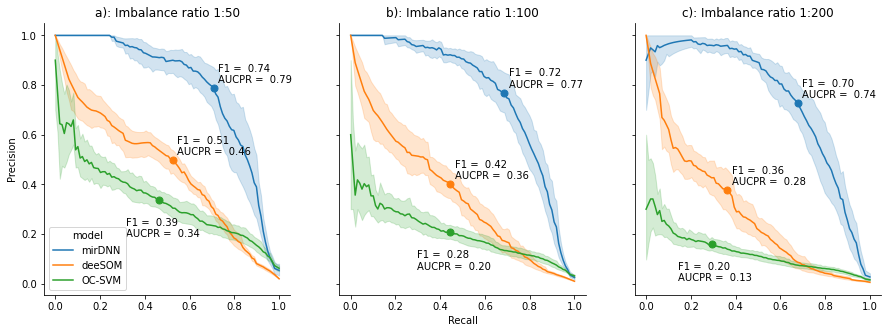

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

models = ["mirDNN", "deeSOM", "OC-SVM"]
imbalances = ["1:50", "1:100", "1:200"]

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for i, imb in enumerate(imbalances):
    legend = False
    if i == 0:
        legend = "auto"
    sns.lineplot(data=df[df.imb==imb], x="recall", y="precision", hue="model", 
                 ax=ax[i], legend=legend)
    for m, model in enumerate(models):
        s = df[(df.model==model) & (df.imb==imb)].groupby("recall").mean()
        x = s.index[s.f1.argmax()]
        y = s.precision.values[int(s.f1.argmax())]
        f1 = s.f1.max()
        auc = s.precision.mean()
        ax[i].plot(x, y, 'o', markersize=7, color=f"C{m}" )
        if model == "OC-SVM":
            difx, dify = -.15, -.15
        else:
            difx, dify = .02, .02

        ax[i].text(x + difx, y + dify, f"F1 = {f1: .2f}\nAUCPR = {auc: .2f}")

        xlab = ""
        if i == 1:
            xlab = "Recall"
        ax[i].set_xlabel(xlab)
        ax[i].set_ylabel("Precision")
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].set_title(f"{['a', 'b', 'c'][i]}): Imbalance ratio {imb}")
